# DATA 620 Final Project: Systemized AirBnB Listings
#### Team Members: Stefano Biguzzi, Ian Costello, Dennis Pong  


### Deliverables Schedule
|Deliverable |Date |Points|
|:---|---|:---:|
|Final Project Proposal|Sunday July 11|25|
|Final Project| Sunday July 18| 150|
|Final Project Presentation| By Video|50|

### Policy on Collaboration 
You may work in a team of up to three people. Each project team member is responsible for understanding and being able to explain all of the submitted project code. Remember that you can take work that you find elsewhere as a base to build on, but you need to acknowledge the source, so that I base your grade on what you contributed, not on what you started with!

### [Final Project Proposal ](https://github.com/sbiguzzi/data620/tree/main/Assignments/FinalProject)
Your proposal should describe at a high level what you’re seeking to accomplish, and your motivation for performing this analysis. A guiding question or hypothesis to test is one good way to start. If you are going to work in a small group (encouraged!), you should also list your partners’ names. 
You should briefly describe your data sources; plan for doing the work, and up front concerns. If you are working in a group, please describe the roles and responsibilities of each group member. 
We’ll treat this proposal as a planning document, not a blue print containing “firm, fixed requirements.” 

### Final Project 
Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 

### Final Project Presentation - YouTube Link
We’ll schedule a short presentation for each team, either in our last scheduled meet-up or in additional office hours to be scheduled during the last week of classes.


## Import Libraries
First we import the libraries we are going to use for the following assignment. `networkx` will be our main library for the network analysis piece.

In [1]:
# general libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import re
import seaborn as sns
from IPython.display import IFrame

# network analysis
import networkx as nx
from networkx.algorithms import bipartite

# text analysis
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# formatting commands
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

## Important Function


In [2]:
# function to get graph components of size one
def component_size_one(G):
    '''Take a graph G and return a list of the 
       connected components of size 1 and the
       number of connected components of size 1'''
    components = [list(G) for G in nx.connected_components(G) if len(G) == 1]
    num_components = len(components)
    return components, num_components

# function to get large graph components
def giant_component_size(G):
    '''Take a graph G and return the largest connected component, 
        a list of the connected components > 1 and 
        the number of connected components > 1'''
    components = [(len(G), list(G)) for G in nx.connected_components(G) if len(G) > 1]
    num_components = len(components)
    GCC = [y[1] for y in components if y[0]
           == max([x[0] for x in components])][0]
    return GCC, components, num_components

# function to clean string
def clean_string(text):
    '''Take any text and return a cleaned version of the text
        without punctuation, lower cased, and removes stopwords'''
    text = ''.join([w for w in text if w not in string.punctuation])
    text = text.lower()
    text = ' '.join([w for w in text.split() if w not in stopwords])
    
    return text

# function to get the ngrams of a word or phrase
def ngrams(string, n=2):
    '''Takes any string removes characters, and creates
        ngrams of length n. Returns string and ngrams of
        string'''
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

# function to get the top n cosine similarity scores
def cos_sim_top(A, B, ntop, lower_bound=0):
    '''Takes any matrix A and B and returns the top n
        matching values with the higest cosine similarity
        score'''
    
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)
    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)
    return csr_matrix((data,indices,indptr),shape=(M,N))

# function to return the names that were run through the cossim_top function
def get_matches_df(sparse_matrix, name_vector, top=None):
    '''Takes any sparse matrix constructed from a name vector
        and returns the names and scores of values in the sparse
        matrix with a defned % cut off'''
    
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similarity': similairity})

In [58]:
os.chdir(r'C:/Users/biguz/Desktop/CUNY Data Science/Summer2021/DATA 620/Assignments/Final Project')

## Loading Data

First step is to load the listing and review data. We check the shape of both data frames and see that the listing_df has 74 columns and 74,840 rows, while the reviews_df has 6 columns and 1,129,280 rows.

In [65]:
# loading listing data
listing_url = r'https://media.githubusercontent.com/media/sbiguzzi/data620/main/Assignments/FinalProject/listings.csv'
listing_df = pd.read_csv(listing_url,dtype=object)
listing_df.rename(columns={'id':'listing_id'},inplace=True)
listing_df.shape

(74840, 74)

In [66]:
# loading reviews data
reviews_url = r'https://media.githubusercontent.com/media/sbiguzzi/data620/main/Assignments/FinalProject/reviews.csv'
reviews_df = pd.read_csv(reviews_url,dtype=object)
reviews_df.shape

(1129280, 6)

## Data Cleaning
We need to clean the data up a bit before we start building to nodes and edges of our network. First we cant to drop rows from the review_df where there are null comments. This removes 503 rows from our data. We also want to remove anything with 'This is an automated posting' in the comment section. This reduces the data by another 19,338 rows. We want to merge the reviews_df columns `['listing_id','reviewr_id','reviewer_name','id','date','comments']` with the listing_df columns `['listing_id','host_id','host_name']` on `listing_id` giving us a dataframe with 1,109,439 rows and 8 columns. We then drop NAs and remove duplicate reviews, shrinking our data by 27,452 rows. We also remove carriage returns from the comments column. Checking the info of the dataframe we see that we have 1,081,987 rows, 8 columns, and no null values. The next step is to construct our network graph.

In [6]:
# drop null comments from review data
reviews_df.dropna(inplace=True)
reviews_df.shape

(1128777, 6)

In [7]:
# drop reviews containing 'This is an automated posting'
automated = reviews_df[reviews_df.comments.str.contains('This is an automated posting')].index
reviews_df.drop(index=automated, inplace=True)
reviews_df.shape

(1109439, 6)

In [123]:
# set up dataframes to merge
df_review = reviews_df[['listing_id', 'reviewer_id', 'reviewer_name', 'id', 'date', 'comments']].copy()
df_listing = listing_df[['listing_id', 'host_id', 'host_name']].copy()

# merge the dataframes
df_merged = pd.merge(df_review, df_listing, how='left', on='listing_id')
df_merged.shape

(1129280, 8)

In [124]:
# clean the merged dataframe
df_merged.dropna(inplace=True)
df_merged.drop_duplicates(subset=['id'], inplace=True)
df_merged.comments = df_merged.comments.map(lambda x: x.replace('\r', ''))
df_merged.reviewer_id = df_merged.reviewer_id.astype(int)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100752 entries, 0 to 1129279
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1100752 non-null  object
 1   reviewer_id    1100752 non-null  int32 
 2   reviewer_name  1100752 non-null  object
 3   id             1100752 non-null  object
 4   date           1100752 non-null  object
 5   comments       1100752 non-null  object
 6   host_id        1100752 non-null  object
 7   host_name      1100752 non-null  object
dtypes: int32(1), object(7)
memory usage: 71.4+ MB


## Creating Network Graph


### Data Wrangling


In [117]:
# calculate the number of reviews per hosts
host_review_counts = df_merged.groupby('host_id')[['id']].nunique().reset_index()
host_review_counts.rename(columns={'id': 'host_review_count'}, inplace=True)

# calculate reviews per reviewer
reviewer_review_counts = df_merged.groupby('reviewer_id')[['id']].nunique().reset_index()
reviewer_review_counts.rename(columns={'id': 'reviewer_review_count'}, inplace=True)

# calculate number of listings by host
host_listing_counts = df_merged.groupby('host_id')[['listing_id']].nunique().reset_index()
host_listing_counts.rename(columns={'listing_id': 'host_listing_counts'}, inplace=True)

# calculate number of hosts reviewed by reviewers
reviewer_host_counts = df_merged.groupby(['reviewer_id'])[['host_id']].nunique().reset_index()
reviewer_host_counts.rename(columns={'host_id': 'reviewer_host_counts'}, inplace=True)

In [127]:
df_merged_final = pd.merge(df_merged, host_review_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_review_counts, how='left', on='reviewer_id')
df_merged_final = pd.merge(df_merged_final, host_listing_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_host_counts, how='left', on='reviewer_id')
df_merged_final.shape

(1100752, 12)

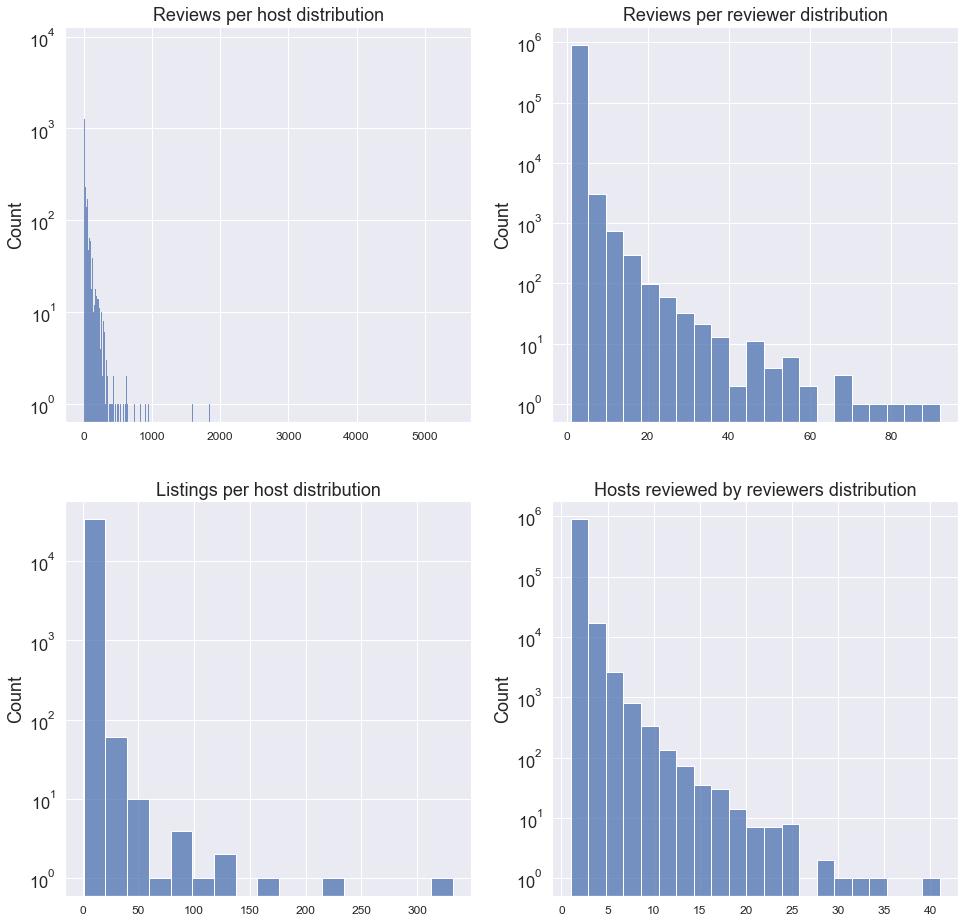

In [121]:
# plot histograms of host counts and reviewer counts
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(16, 16))
sns.histplot(host_review_counts.host_review_count, ax=ax[0,0])
sns.histplot(reviewer_review_counts.reviewer_review_count, ax=ax[0,1])
sns.histplot(host_listing_counts.host_listing_counts, ax=ax[1,0])
sns.histplot(reviewer_host_counts.reviewer_host_counts, ax=ax[1,1])
ax[0,0].set_title('Reviews per host distribution')
ax[0,1].set_title('Reviews per reviewer distribution')
ax[1,0].set_title('Listings per host distribution')
ax[1,1].set_title('Hosts reviewed by reviewers distribution')

for a in ax.flatten():
    a.set_xlabel('')
    a.tick_params(axis='x', labelsize=12, labelrotation=0)
    a.set_yscale('log')

plt.show()

In [128]:
df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep=False)].copy()

,listing_id,reviewer_id,reviewer_name,id,date,comments,host_id,host_name,host_review_count,reviewer_review_count,host_listing_counts,reviewer_host_counts
136,11551,16215906,Susan,36517241,2015-06-29,We were so looking forward to meeting Adriano ...,43039,Adriano,194.0,3.0,2.0,2.0
139,11551,16215906,Susan,38910059,2015-07-19,Adriano is a most delightful person. We met hi...,43039,Adriano,194.0,3.0,2.0,2.0
164,11551,2616693,Jeff,131190343,2017-02-11,I had a great stay in Adriano's flat. Fantast...,43039,Adriano,194.0,13.0,2.0,5.0
271,15400,51941207,Kurt,76869648,2016-05-29,The flat is amazing. Its close to the bus stop...,60302,Philippa,89.0,2.0,1.0,1.0
286,15400,51941207,Kurt,154393318,2017-05-24,"Beautiful place, close to everything!!",60302,Philippa,89.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1100612,48585501,224436857,Yasen,747011455,2021-04-09,Recommended to all 10/10 stay and hospitality,2760519,Pedro,3.0,7.0,2.0,5.0
1100665,48693512,369553775,Duncan,741896516,2021-03-24,"Arrived and the bed was completely broken, had...",21867370,Robert,745.0,3.0,30.0,2.0
1100696,48819136,22243518,Stella,742326996,2021-03-26,I am so happy I booked this big and spacious f...,50112313,Alex,92.0,2.0,9.0,1.0
1100705,48836953,375990,Tj,746759555,2021-04-08,great location walking distance to everything....,119131088,Agustina,6.0,2.0,1.0,1.0


In [169]:
subset = df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep=False)].copy()
subset = subset[subset.host_listing_counts >= 5]
subset = subset[subset.reviewer_host_counts > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], keep=False, inplace=True)
subset.shape

(3444, 12)

In [170]:
print('Number of reviewers: ', len(subset.reviewer_id.unique()))
print('Number of hosts: ', len(subset.host_id.unique()))

Number of reviewers:  1019
Number of hosts:  349


In [171]:
hosts = dict(subset[['host_id', 'host_name']].values)
reviewers = dict(subset[['reviewer_id', 'reviewer_name']].values)
labels_dict = {**reviewers, **hosts}

### Initial 2-Mode Network

In [172]:
G = nx.Graph()
G.add_nodes_from(subset.reviewer_id.unique(), bipartite=0)
G.add_nodes_from(subset.host_id.unique(), bipartite=1)
G.add_edges_from(subset[['reviewer_id', 'host_id']].values)

In [173]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1368
Number of edges: 1174
Average degree:   1.7164


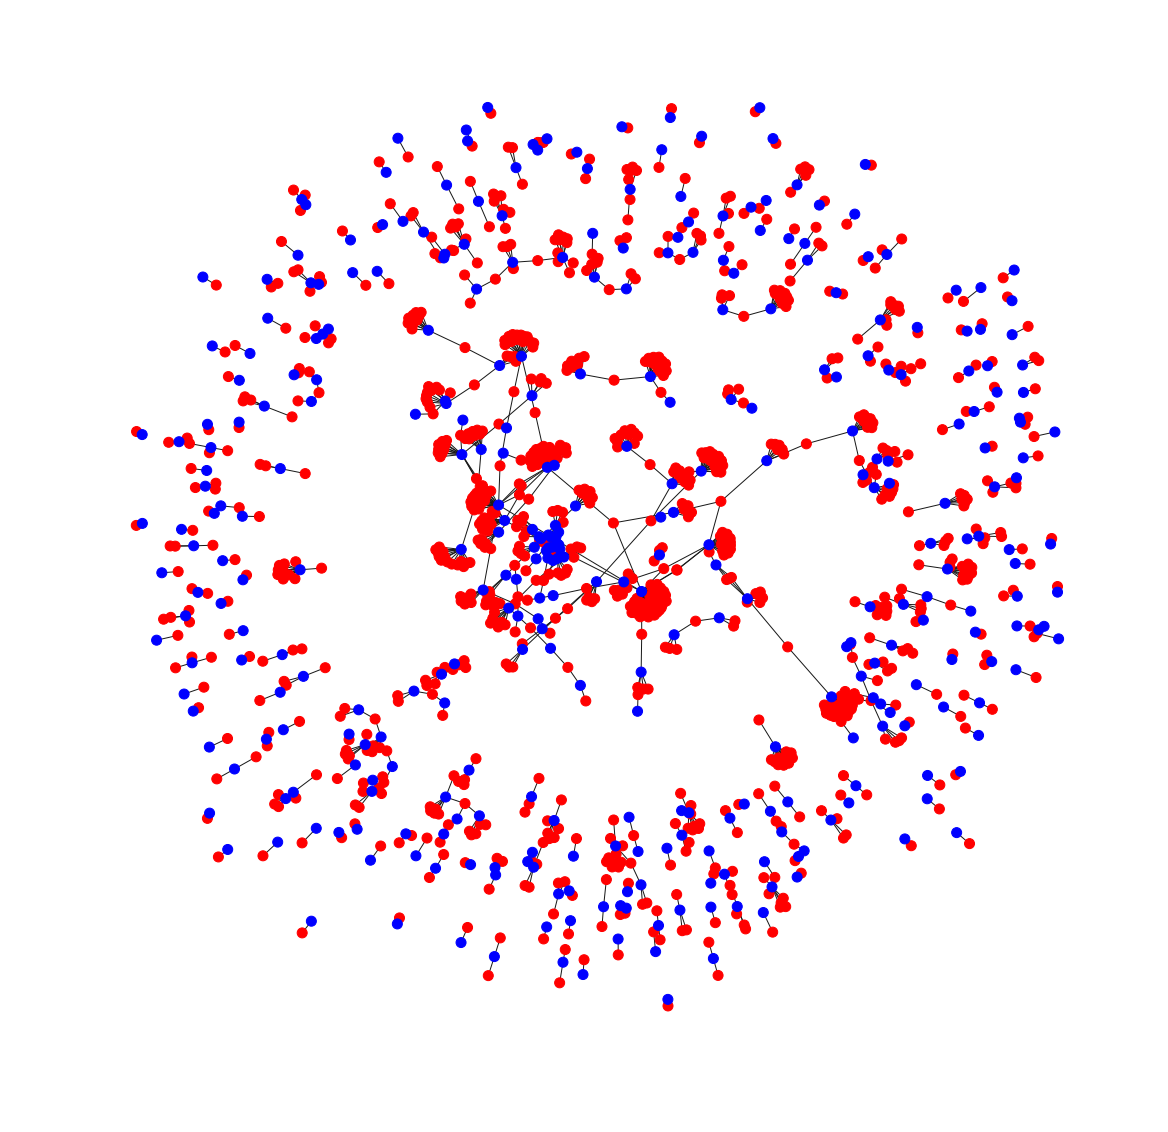

In [174]:
# nodes
reviewer_nodes = subset.reviewer_id.unique().tolist()
host_nodes = subset.host_id.unique().tolist()

# create plot
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G,iterations=35)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)))
nx.draw_networkx_edges(G, pos, width=1)
plt.axis("off")
plt.show()

### Bipartite host graph

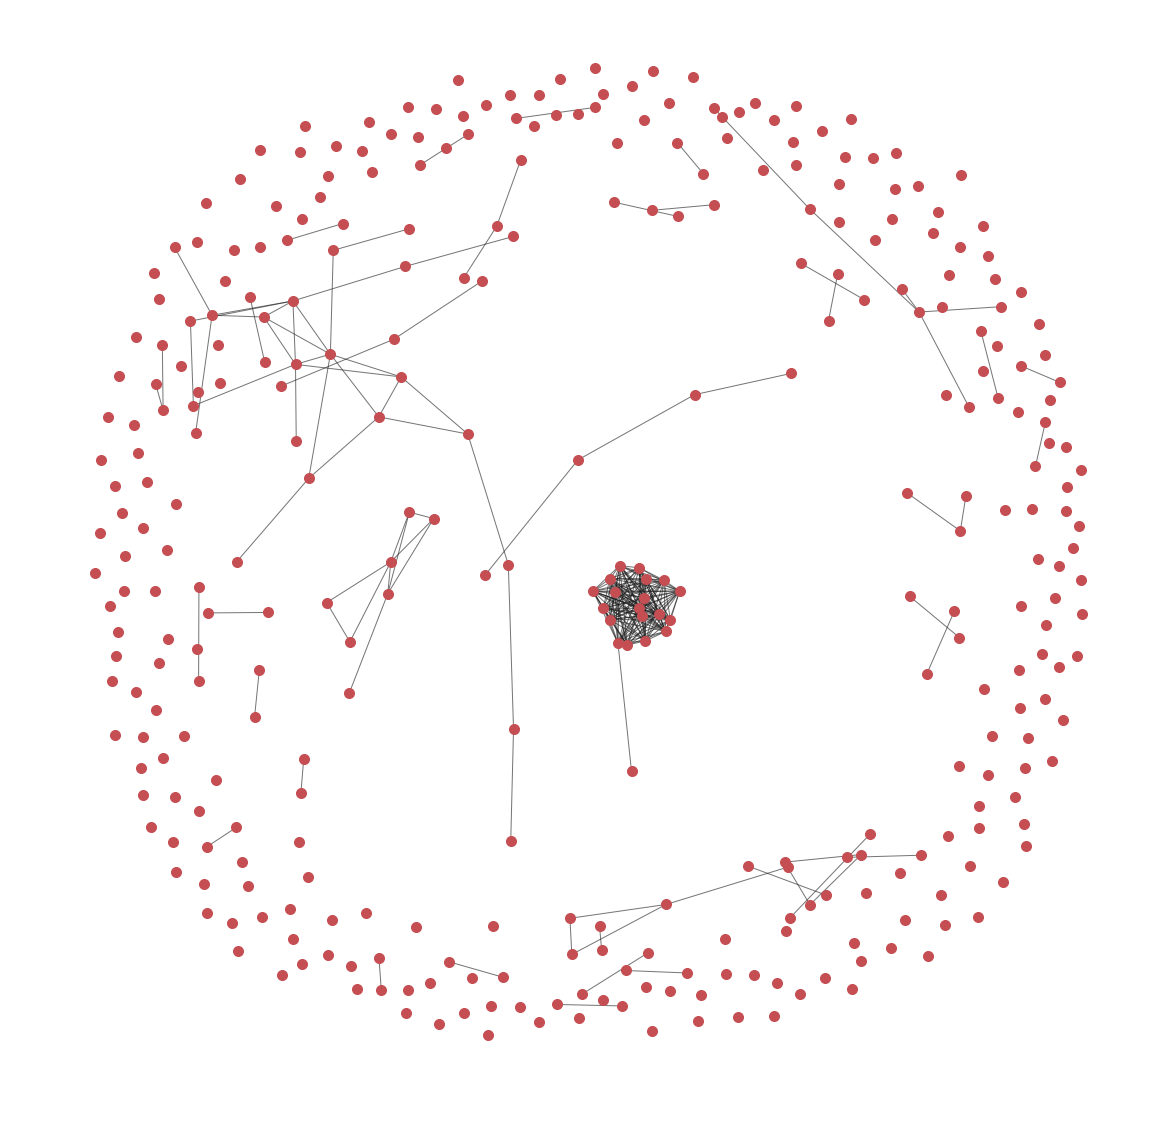

In [175]:
# look at projected graph (on hosts)
host_nodes = subset.host_id.unique().tolist()
B = bipartite.projected_graph(G, host_nodes)

pos = nx.spring_layout(B,iterations=15)
labels = {node: labels_dict[node] for node in B.nodes()}

# create plot
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(B, pos, node_size=100)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.6)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=10, font_family="sans-serif")
plt.axis("off")
plt.show()

In [176]:
# identify the components with no links
components_one, n_one = component_size_one(B)
components_one = [item for sublist in components_one for item in sublist]

print("Number of components:\n", n_one)

Number of components:
 215


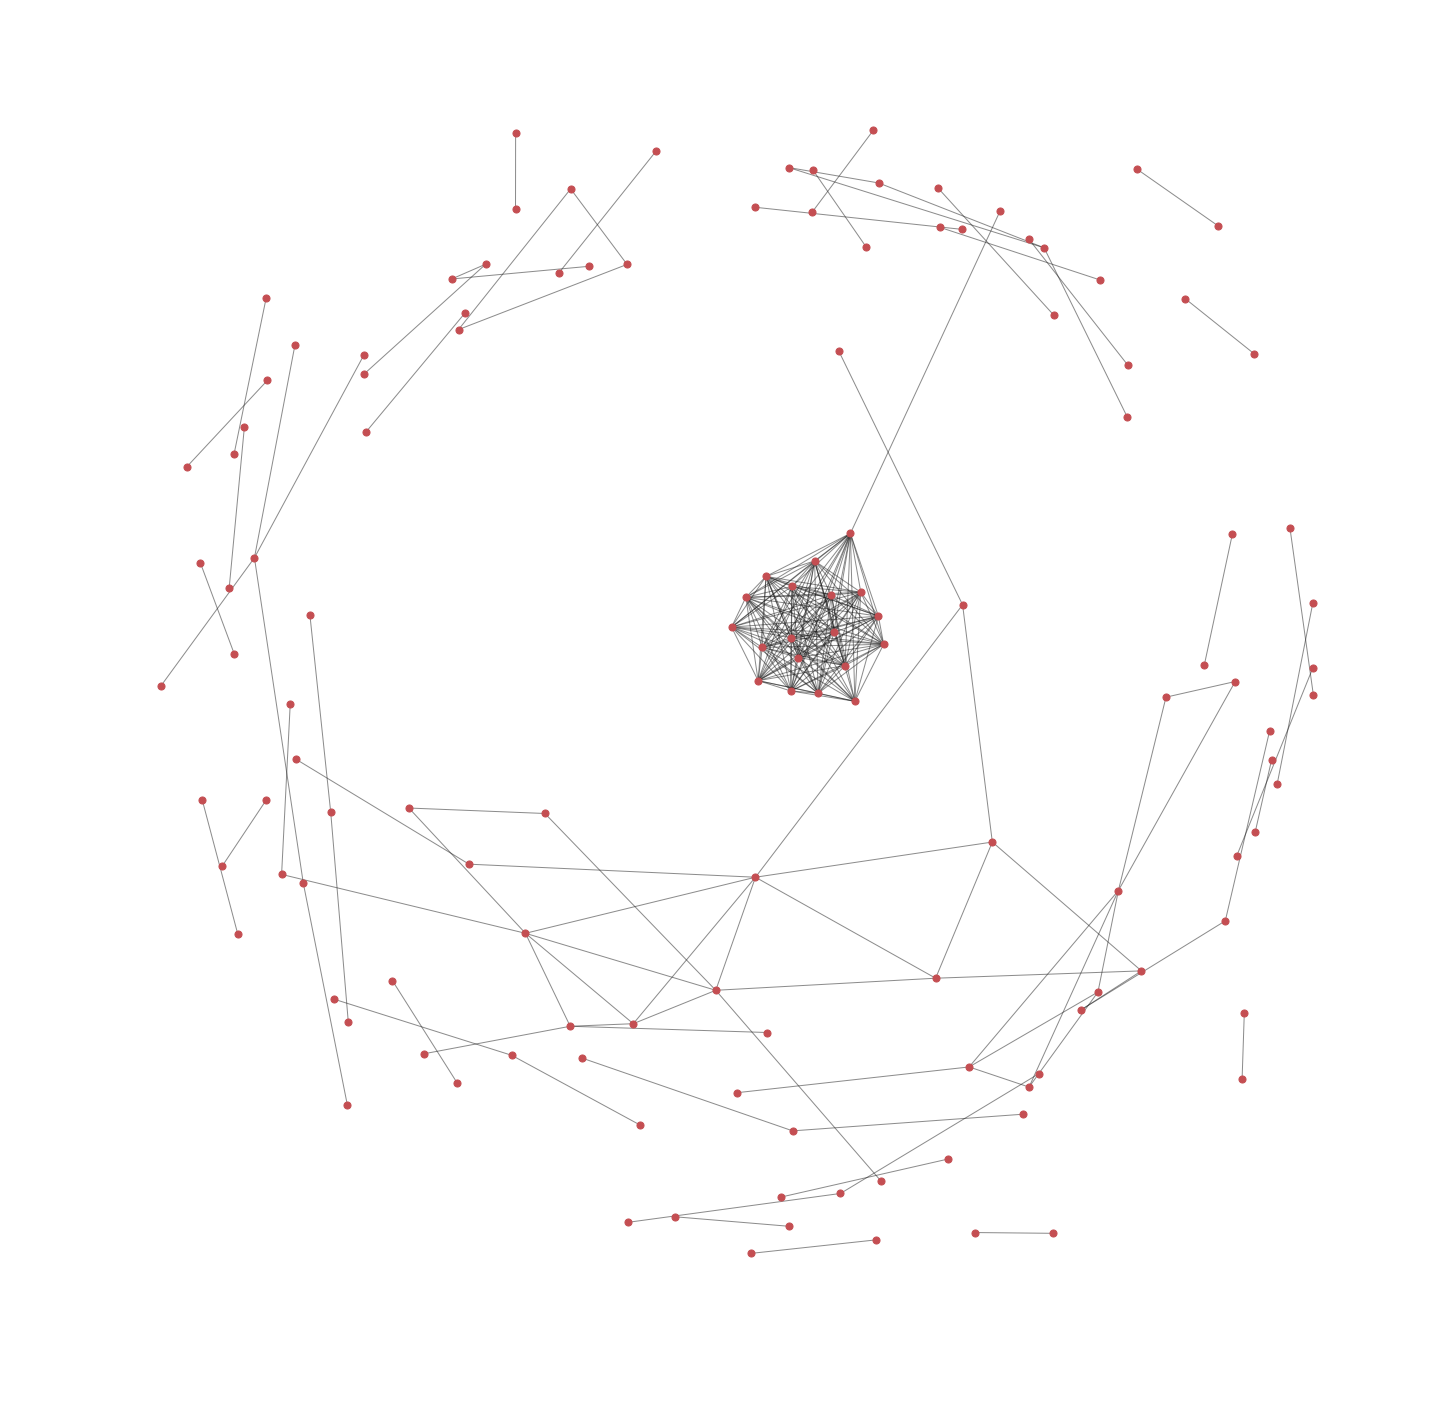

In [177]:
# remove the hosts with no links and plot the remaining ones
B.remove_nodes_from(components_one)

pos = nx.spring_layout(B,iterations=16)
labels = {node: labels_dict[node] for node in B.nodes()}

plt.figure(figsize=(25,25))
# nx.draw_networkx(B, pos, with_labels=False, node_size=100)
nx.draw_networkx_nodes(B, pos, node_size=50)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.5)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=12, font_family="sans-serif")
plt.axis("off")
plt.show()

In [144]:
GCC, components, n = giant_component_size(B)
print("Number of components:\n", n)

Number of components:
 441


In [23]:
listing_df[['host_name','host_url']][listing_df['host_id'].isin(components[3][1])].drop_duplicates()

,host_name,host_url
387,Christina,https://www.airbnb.com/users/show/1775224
846,Jelena,https://www.airbnb.com/users/show/2531619
871,Dana,https://www.airbnb.com/users/show/2605151
1441,Alexandra,https://www.airbnb.com/users/show/4365977
2998,Vesna,https://www.airbnb.com/users/show/13321221
3001,Muse,https://www.airbnb.com/users/show/3838050
3105,Inge,https://www.airbnb.com/users/show/1807787
3246,Rada And Alexandra,https://www.airbnb.com/users/show/15436013
6510,Emrah,https://www.airbnb.com/users/show/28381203
12685,Nev,https://www.airbnb.com/users/show/27349958


In [24]:
listing_df[['host_name','host_url']][listing_df['host_id'].isin(components[11][1])].drop_duplicates()

,host_name,host_url
10467,Sam & Marta,https://www.airbnb.com/users/show/40303198
17497,Sam And Chris,https://www.airbnb.com/users/show/87794098
18497,Tom & Mary,https://www.airbnb.com/users/show/96333789
19765,Dan And Hanna,https://www.airbnb.com/users/show/105125907
22029,Martha N Samuel,https://www.airbnb.com/users/show/120045094
22069,LondonFlats DFM,https://www.airbnb.com/users/show/50400563
24417,Sam,https://www.airbnb.com/users/show/122890980
24444,"Sam, Joe",https://www.airbnb.com/users/show/122820136
26584,Chris & Sam,https://www.airbnb.com/users/show/142504860
29842,Chris N Sam,https://www.airbnb.com/users/show/158029757


In [25]:
listing_df[['host_name','host_url']][listing_df['host_id'].isin(components[19][1])].drop_duplicates()

,host_name,host_url
14170,Alex,https://www.airbnb.com/users/show/1504322
17419,Max And Billie,https://www.airbnb.com/users/show/82436841
18303,Tyrone,https://www.airbnb.com/users/show/69479387
30759,Sonder,https://www.airbnb.com/users/show/12243051
39026,Park Lane,https://www.airbnb.com/users/show/102490355
42718,Billie And Max,https://www.airbnb.com/users/show/226472167
43056,Sonder (London),https://www.airbnb.com/users/show/224866971


In [26]:
listing_df[['host_name','host_url']][listing_df['host_id'].isin(components[21][1])].drop_duplicates()

,host_name,host_url
22603,James,https://www.airbnb.com/users/show/95565283
54899,Justin,https://www.airbnb.com/users/show/288665110


In [27]:
listing_df[['host_name','host_url']][listing_df['host_id'].isin(components[22][1])].drop_duplicates()

,host_name,host_url
23881,Serge,https://www.airbnb.com/users/show/130274729
26591,Serge,https://www.airbnb.com/users/show/142448518


In [28]:
listing_df[['host_name','host_url']][listing_df['host_id'].isin(components[35][1])].drop_duplicates()

,host_name,host_url
48556,Sverrir & Vesta,https://www.airbnb.com/users/show/258580205
60518,Eric & Vesta,https://www.airbnb.com/users/show/316840797


## Potential Success

In [56]:
reviews_df.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

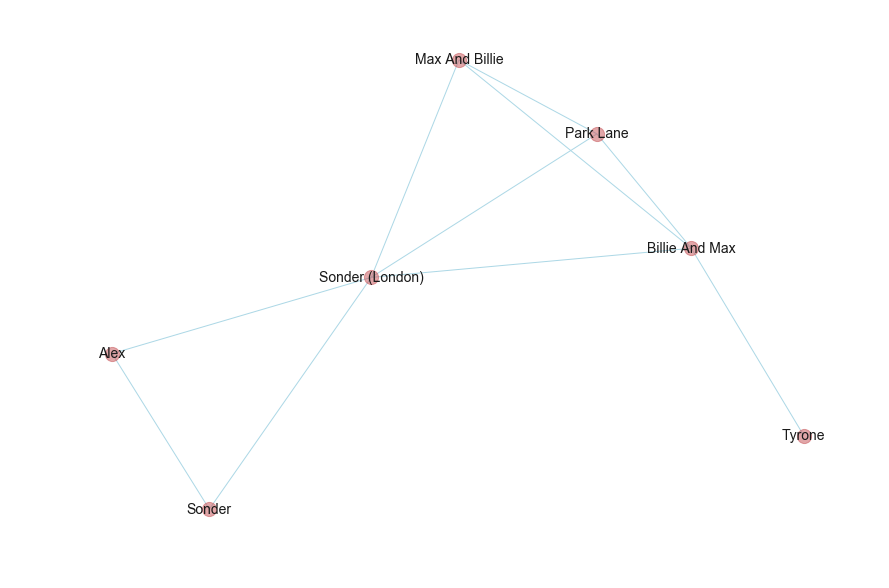

In [29]:
# plot one of the components
B_sub_1 = B.subgraph(components[19][1])

pos = nx.spring_layout(B_sub_1)
labels = {node: labels_dict[node] for node in B_sub_1.nodes()}

# create plot
plt.figure(figsize=(15,10))
nx.draw_networkx_nodes(B_sub_1, pos, node_size=200,color='red',alpha=0.5)
nx.draw_networkx_edges(B_sub_1, pos, width=1, edge_color='lightblue')
nx.draw_networkx_labels(B_sub_1, pos, labels=labels, font_size=14, font_family="sans-serif")
plt.axis("off")
plt.show()

In [30]:
network_1 = subset[subset.host_id.isin(components[19][1])]

# plot network with reviewers added back in
G_net_1 = nx.Graph()
G_net_1.add_nodes_from(network_1.reviewer_id.unique(), bipartite=0)
G_net_1.add_nodes_from(network_1.host_id.unique(), bipartite=1)
G_net_1.add_edges_from(network_1[['reviewer_id', 'host_id']].values)

# node attributes
node_data = {}
for node in G_net_1:
    if node in network_1.reviewer_id.unique():
        node_data.update({node:'reviewer'})
    if node in network_1.host_id.unique():
        node_data.update({node:'host'})

nx.set_node_attributes(G_net_1,'labels',node_data)

In [31]:
Gnet1_cent_df = pd.DataFrame(nx.degree_centrality(G_net_1).items(),columns=['graph_id','degree'])
Gnet1_cent_df['eigenvector'] = nx.eigenvector_centrality_numpy(G_net_1).values()
Gnet1_cent_df['betweenness'] = nx.betweenness_centrality(G_net_1).values()
Gnet1_cent_df['closeness'] = nx.closeness_centrality(G_net_1).values()
Gnet1_cent_df.merge(pd.DataFrame(node_data.items(),columns=['graph_id','label']),on='graph_id',how='left').sort_values('betweenness',ascending=False).head(n=10)

,graph_id,degree,eigenvector,betweenness,closeness,label
53,226472167,0.218182,0.192638,0.582828,0.374150,host
49,82436841,0.345455,0.674053,0.531650,0.354839,host
17,8688619,0.072727,0.222861,0.528620,0.401460,reviewer
54,224866971,0.127273,0.073719,0.374747,0.329341,host
50,69479387,0.200000,0.022002,0.333333,0.258216,host
26,94147884,0.036364,0.048291,0.325926,0.307263,reviewer
20,21245807,0.054545,0.019819,0.169697,0.263158,reviewer
16,250111091,0.036364,0.194994,0.133333,0.333333,reviewer
51,1504322,0.072727,0.005257,0.107071,0.214008,host
52,12243051,0.054545,0.009113,0.038047,0.212355,host


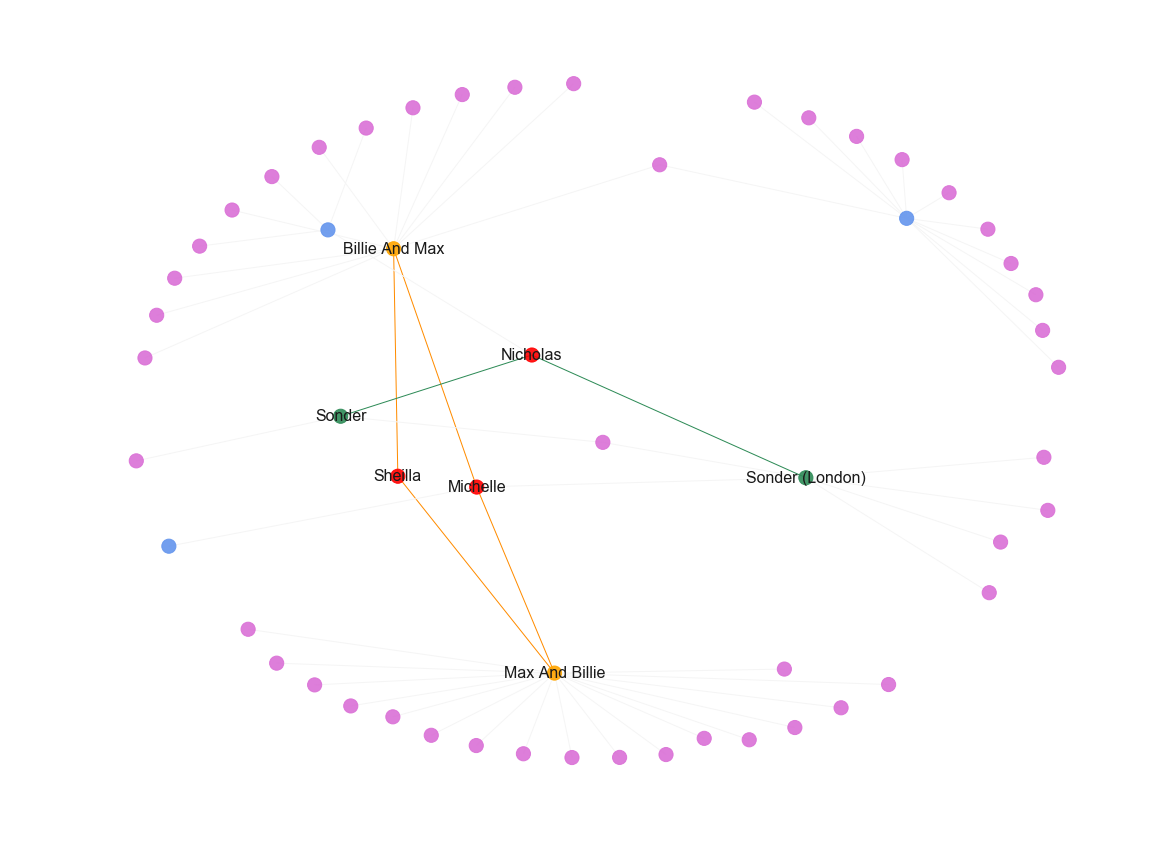

In [32]:
# node color
colors_net_1 = []
for node in G_net_1.nodes():
    if node in [8688619,250111091,21245807]:
        colors_net_1.append('red')
    elif node in ['226472167','82436841']:
        colors_net_1.append('orange')
    elif node in ['224866971','12243051']:
        colors_net_1.append('seagreen')
    elif node in network_1.host_id.unique():
        colors_net_1.append('cornflowerblue')
    else:
        colors_net_1.append('orchid')

# edge color
edge_color_net_1 = []
for edge in G_net_1.edges():
    if any([val in edge for val in ['226472167','82436841']]) & any([val in edge for val in [8688619,250111091]]):
        edge_color_net_1.append('darkorange')
    elif any([val in edge for val in [21245807]]) & any([val in edge for val in ['224866971','12243051']]):
        edge_color_net_1.append('seagreen')
    else:
        edge_color_net_1.append('whitesmoke')
        
# nodes
reviewer_nodes = network_1.reviewer_id.unique()
host_nodes = network_1.host_id.unique()
labels = {node: labels_dict[node] for node in ['224866971','12243051','226472167','82436841',8688619,250111091,21245807]}

#### ['red']*len(reviewer_nodes) + ['blue']*(len(host_nodes))

# create plot
plt.figure(figsize=(20,15))
pos = nx.spring_layout(G_net_1,iterations=60)
nx.draw_networkx_nodes(G_net_1, pos, node_size=200, node_color=colors_net_1, alpha=0.9)
nx.draw_networkx_edges(G_net_1, pos, width=1, edge_color=edge_color_net_1, alpha=1)
nx.draw_networkx_labels(G_net_1, pos, labels=labels, font_size=16, font_family="sans-serif")
plt.axis("off")
plt.show()

In [33]:
names_net1_df = listing_df[['host_name','host_id']][listing_df['host_id'].isin(components[19][1])].drop_duplicates().reset_index(drop=True)
for w in names_net1_df['host_name']:
    w1 = w.lower()
    for ele in w1:
        if ele in string.punctuation+' ':
            w1 = w1.replace(ele,'')
    names_net1_df['host_name'].replace(w,w1,inplace=True)
names_net_1 = names_net1_df['host_name']
names_net_1.head()

0            alex
1    maxandbillie
2          tyrone
3          sonder
4        parklane
Name: host_name, dtype: object

In [34]:
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
tf_idf_matrix_net_1 = vectorizer.fit_transform(names_net_1)
matches_net_1 = cos_sim_top(tf_idf_matrix_net_1, tf_idf_matrix_net_1.transpose(), 10, 0.6)
matches_net1_df = get_matches_df(matches_net_1, names_net_1,top=None)
matches_net1_df = matches_net1_df[matches_net1_df['similarity'] < 0.99999]
matches_net1_df = matches_net1_df.rename(columns={'left_side':'host_name'}).merge(names_net1_df,on='host_name',how='left').merge(listing_df[['host_id','host_url']].drop_duplicates(),on='host_id',how='left')
matches_net1_df = matches_net1_df.rename(columns = {'host_name':'host_left','right_side':'host_names',
                                                    'host_url':'host_url_left','right_side':'host_name'}).drop('host_id',axis=1).merge(names_net1_df,on='host_name',how='left').merge(listing_df[['host_id','host_url']].drop_duplicates(),on='host_id',how='left')
matches_net1_df = matches_net1_df.rename(columns={'host_url':'host_url_right','host_name':'host_right'}).drop('host_id',axis=1)
matches_net1_df.drop_duplicates('similarity').sort_values('similarity',ascending=False).reset_index(drop=True)

,host_left,host_right,similarity,host_url_left,host_url_right
0,sonder,sonderlondon,0.757253,https://www.airbnb.com/users/show/12243051,https://www.airbnb.com/users/show/224866971
1,maxandbillie,billieandmax,0.740469,https://www.airbnb.com/users/show/82436841,https://www.airbnb.com/users/show/226472167


In [35]:
print("Max and Billie Profile Pic")
IFrame(src="https://a0.muscache.com/im/pictures/user/6e64d32a-cb3a-439f-b219-9da9880d1c02.jpg",width="100%",height="725")

Max and Billie Profile Pic


In [36]:
print("Billie and Max Profile Pic")
IFrame(src="https://a0.muscache.com/im/pictures/user/88efc61a-5a9b-436a-a9d8-b7ec9d9d26fd.jpg",width="100%",height="1280")

Billie and Max Profile Pic


## Success and Failure

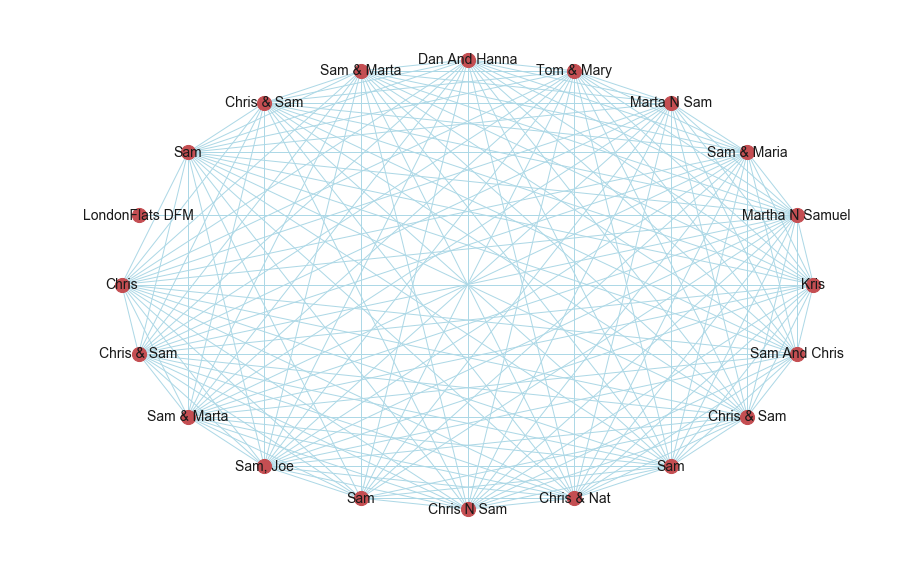

In [37]:
# plot one of the components
B_sub_2 = B.subgraph(components[11][1])

pos = nx.shell_layout(B_sub_2)
labels = {node: labels_dict[node] for node in B_sub_2.nodes()}

# create plot
plt.figure(figsize=(15,10))
nx.draw_networkx_nodes(B_sub_2, pos, node_size=200)
nx.draw_networkx_edges(B_sub_2, pos, width=1, edge_color='lightblue')
nx.draw_networkx_labels(B_sub_2, pos, labels=labels, font_size=14, font_family="sans-serif")
plt.axis("off")
plt.show()

In [38]:
network_2 = subset[subset.host_id.isin(components[11][1])]

# plot network with reviewers added back in
G_net_2 = nx.Graph()
G_net_2.add_nodes_from(network_2.reviewer_id.unique(), bipartite=0)
G_net_2.add_nodes_from(network_2.host_id.unique(), bipartite=1)
G_net_2.add_edges_from(network_2[['reviewer_id', 'host_id']].values)

# node attributes
node_data = {}
for node in G_net_2:
    if node in network_2.reviewer_id.unique():
        node_data.update({node:'reviewer'})
    if node in network_2.host_id.unique():
        node_data.update({node:'host'})

nx.set_node_attributes(G_net_2,'label',node_data)

In [39]:
Gnet2_cent_df = pd.DataFrame(nx.degree_centrality(G_net_2).items(),columns=['graph_id','degree'])
Gnet2_cent_df['eigenvector'] = nx.eigenvector_centrality_numpy(G_net_2).values()
Gnet2_cent_df['betweenness'] = nx.betweenness_centrality(G_net_2).values()
Gnet2_cent_df['closeness'] = nx.closeness_centrality(G_net_2).values()
Gnet2_cent_df.merge(pd.DataFrame(node_data.items(),columns=['graph_id','label']),on='graph_id',how='left').sort_values('betweenness',ascending=False).head(n=10)

,graph_id,degree,eigenvector,betweenness,closeness,label
10,126296511,0.400000,0.398378,0.342741,0.592105,reviewer
11,89142722,0.333333,0.339092,0.217591,0.500000,reviewer
0,59067496,0.333333,0.359549,0.202345,0.535714,reviewer
28,96333789,0.177778,0.199310,0.176364,0.441176,host
26,40303198,0.177778,0.199310,0.176364,0.441176,host
27,87794098,0.155556,0.149083,0.173303,0.416667,host
31,122890980,0.155556,0.164645,0.156744,0.432692,host
32,122820136,0.133333,0.191536,0.092526,0.424528,host
30,120045094,0.088889,0.153223,0.088863,0.416667,host
1,60252847,0.222222,0.248570,0.079705,0.424528,reviewer


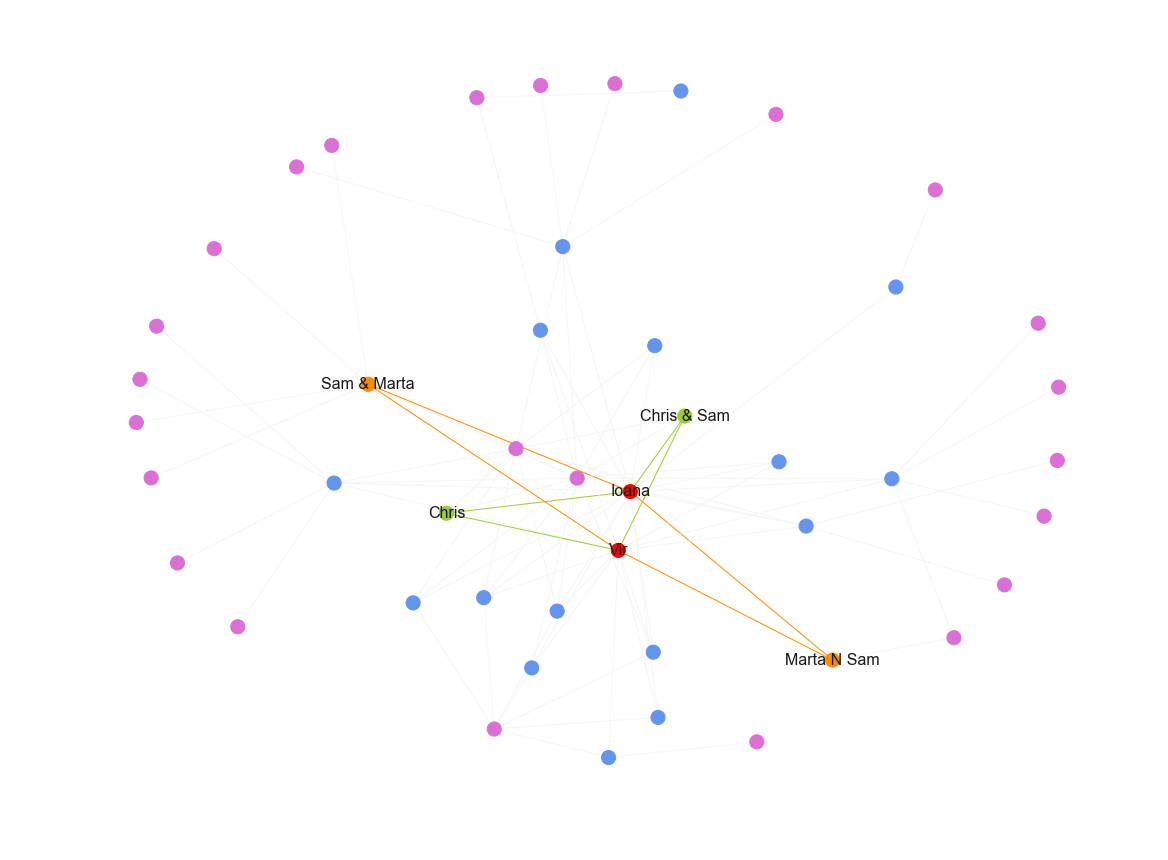

In [40]:
# node color
colors_net_2 = []
for node in G_net_2.nodes():
    if node in [126296511,89142722]:
        colors_net_2.append('red')
    elif node in ['188935918','40303198']:
        colors_net_2.append('darkorange')
    elif node in ['142504860','158895056']:
        colors_net_2.append('yellowgreen')
    elif node in network_2.host_id.unique():
        colors_net_2.append('cornflowerblue')
    else:
        colors_net_2.append('orchid')

# edge color
edge_color_net_2 = []
for edge in G_net_2.edges():
    if any([val in edge for val in [126296511,89142722]]) & any([val in edge for val in ['188935918','40303198']]):
        edge_color_net_2.append('darkorange')
    elif any([val in edge for val in [126296511,89142722]]) & any([val in edge for val in ['142504860','158895056']]):
        edge_color_net_2.append('yellowgreen')
    else:
        edge_color_net_2.append('whitesmoke')

# nodes
reviewer_nodes = network_2.reviewer_id.unique()
host_nodes = network_2.host_id.unique()
labels = {node: labels_dict[node] for node in ['158895056','142504860','188935918','40303198',126296511,89142722]}

# create plot
plt.figure(figsize=(20,15))
pos = nx.spring_layout(G_net_2,iterations=60)
nx.draw_networkx_nodes(G_net_2, pos, node_size=200, node_color=colors_net_2, alpha=1)
nx.draw_networkx_edges(G_net_2, pos, width=1, edge_color=edge_color_net_2, alpha=1)
nx.draw_networkx_labels(G_net_2, pos, labels=labels, font_size=16, font_family="sans-serif")
plt.axis("off")
plt.show()

In [41]:
names_net2_df = listing_df[['host_name','host_id']][listing_df['host_id'].isin(components[11][1])].drop_duplicates().reset_index(drop=True)
for w in names_net2_df['host_name']:
    w1 = w.lower()
    for ele in w1:
        if ele in string.punctuation+' ':
            w1 = w1.replace(ele,'')
    names_net2_df['host_name'].replace(w,w1,inplace=True)
names_net_2 = names_net2_df['host_name']
names_net_2.head()

0         sammarta
1      samandchris
2          tommary
3      danandhanna
4    marthansamuel
Name: host_name, dtype: object

In [44]:
tf_idf_matrix_net_2 = vectorizer.fit_transform(names_net_2)
matches_net_2 = cos_sim_top(tf_idf_matrix_net_2, tf_idf_matrix_net_2.transpose(), 10, 0.7)
matches_net2_df = get_matches_df(matches_net_2, names_net_2,top=None)
matches_net2_df = matches_net2_df[matches_net2_df['similarity'] < 0.99999]
matches_net2_df = matches_net2_df.rename(columns={'left_side':'host_name'
                                       }).merge(names_net2_df,on='host_name',how='left').merge(listing_df[['host_id','host_url']].drop_duplicates(),on='host_id',how='left')
matches_net2_df = matches_net2_df.rename(columns = {'host_name':'host_left',
                                          'right_side':'host_names',
                                          'host_url':'host_url_left',
                                          'right_side':'host_name'
                                         }).drop('host_id',axis=1).merge(names_net2_df,on='host_name',how='left').merge(listing_df[['host_id','host_url']].drop_duplicates(),on='host_id',how='left')
matches_net2_df = matches_net2_df.rename(columns={'host_url':'host_url_right',
                                            'host_name':'host_right'
                                           }).drop('host_id',axis=1)
matches_net2_df.drop_duplicates('similarity').sort_values('similarity',ascending=False).reset_index(drop=True)

,host_left,host_right,similarity,host_url_left,host_url_right
0,chrissam,chris,0.755761,https://www.airbnb.com/users/show/142504860,https://www.airbnb.com/users/show/158895056
1,sammarta,martansam,0.727964,https://www.airbnb.com/users/show/40303198,https://www.airbnb.com/users/show/188935918


### Success

In [45]:
print("Sam & Marta Profile Pic")
IFrame(src="https://a0.muscache.com/im/pictures/user/7e4aef35-2d61-4fa1-ba55-939aeaf1abf1.jpg",width="355",height="339")

Sam & Marta Profile Pic


In [55]:
print("Marta N Sam Profile Pic")
IFrame(src="https://a0.muscache.com/im/pictures/user/3ec7354d-edda-433b-a5c4-6361d7dd6266.jpg?aki_policy=profile_x_medium",width="250",height="250")

Marta N Sam Profile Pic


### Failure

In [47]:
print("Chris & Sam Profile Pic")
IFrame(src="https://a0.muscache.com/im/pictures/user/692443d9-1039-424f-a8cb-1ad09f9e6ee6.jpg?aki_policy=profile_x_medium",width="250px",height="250px")

Chris & Sam Profile Pic


In [48]:
print("Chris Profile Pic")
IFrame(src="https://a0.muscache.com/im/pictures/user/1d1ee1dc-17ff-4831-8da6-478bae1a3b14.jpg",width="175",height="225")

Chris Profile Pic
